Unzip + verify folders

In [ ]:
!unzip dataset.zip -d /content/
!ls /content/dataset/

Archive:  dataset.zip
   creating: /content/dataset/
   creating: /content/dataset/adult_sound/
  inflating: /content/dataset/adult_sound/adult_chunk_001.mp3  
  inflating: /content/dataset/adult_sound/adult_chunk_002.mp3  
  inflating: /content/dataset/adult_sound/adult_chunk_003.mp3  
  inflating: /content/dataset/adult_sound/adult_chunk_004.mp3  
  inflating: /content/dataset/adult_sound/adult_chunk_005.mp3  
  inflating: /content/dataset/adult_sound/adult_chunk_006.mp3  
  inflating: /content/dataset/adult_sound/adult_chunk_007.mp3  
  inflating: /content/dataset/adult_sound/adult_chunk_008.mp3  
  inflating: /content/dataset/adult_sound/adult_chunk_009.mp3  
  inflating: /content/dataset/adult_sound/adult_chunk_010.mp3  
  inflating: /content/dataset/adult_sound/adult_chunk_011.mp3  
  inflating: /content/dataset/adult_sound/adult_chunk_012.mp3  
  inflating: /content/dataset/adult_sound/adult_chunk_013.mp3  
  inflating: /content/dataset/adult_sound/adult_chunk_014.mp3  
  inflat

Imports + paths + labels
AUDIO_LABELS = ["adult_sound", "child_cry", "child_sounds", "noise", "pet_sound","silence"]

In [ ]:
import os
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt

base_path = "/content/dataset"
categories = ["adult_sound", "child_cry", "child_sounds", "noise", "pet_sound","silence"]

label_map = {
    "adult_sound": 0,
    "child_cry": 1,
    "child_sounds": 2,
    "noise": 3,
    "pet_sound": 4,
     "silence":5
}


Plot one mel-spectrogram per class

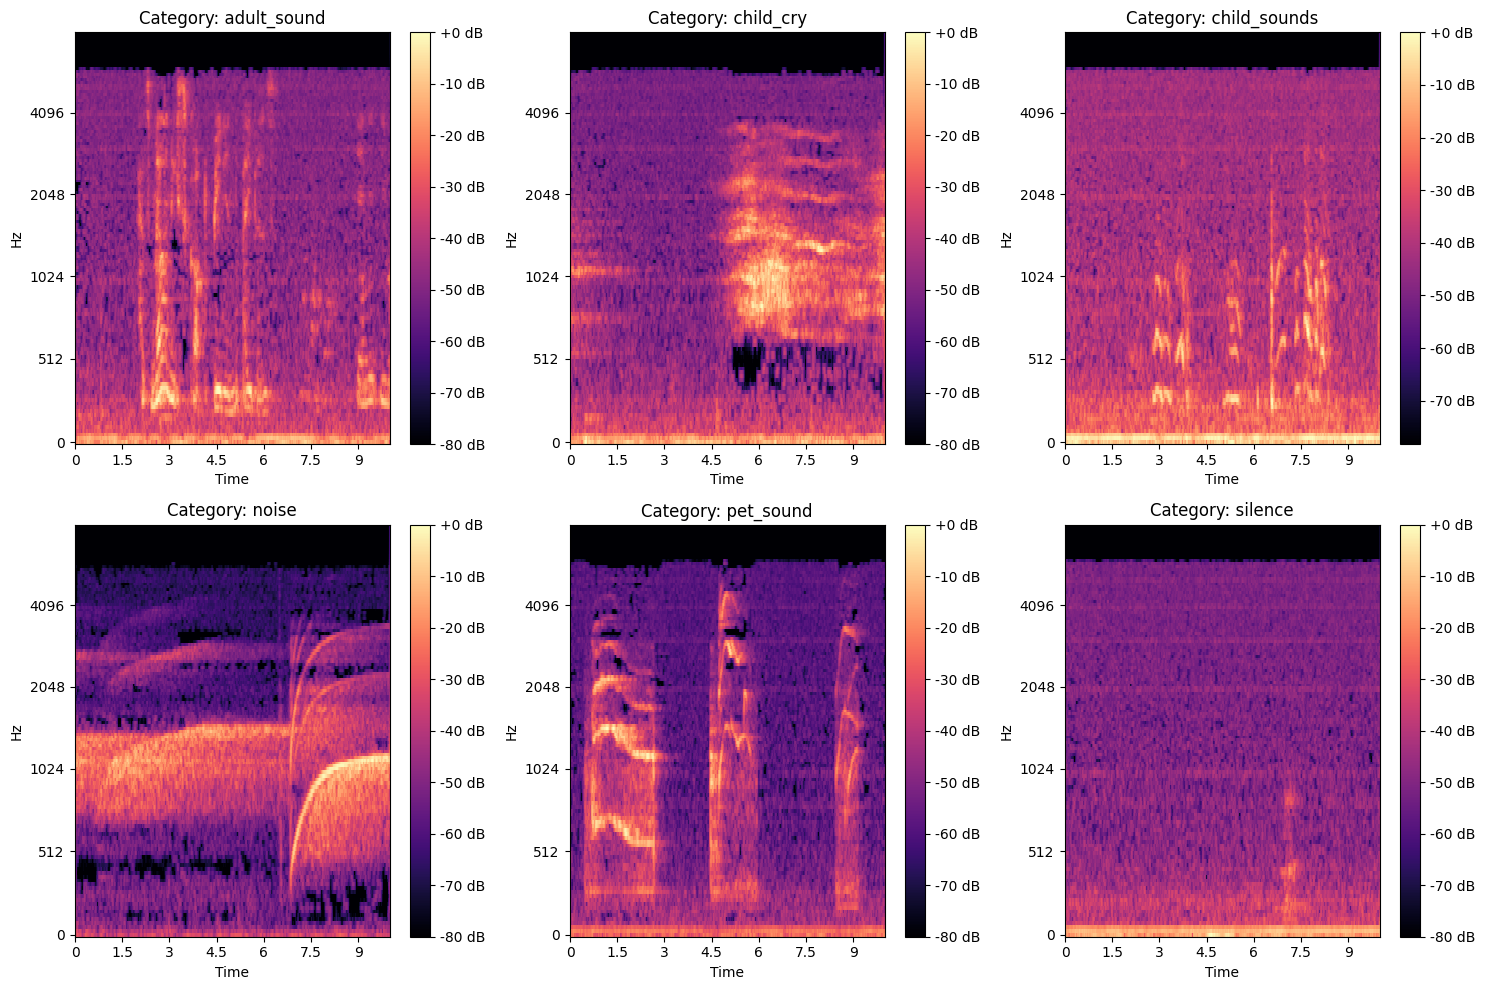

In [ ]:
def first_audio_file(folder_path):
    exts = (".wav", ".ogg", ".mp3", ".flac", ".m4a")
    files = [f for f in os.listdir(folder_path) if f.lower().endswith(exts)]
    return files[0] if files else None

def plot_sample_spectrograms(base_path, categories):
    plt.figure(figsize=(15, 10))

    for i, category in enumerate(categories):
        folder_path = os.path.join(base_path, category)
        sample_file = first_audio_file(folder_path)

        if sample_file is None:
            print(f"⚠️ No audio found in {category}")
            continue

        file_path = os.path.join(folder_path, sample_file)

        y, sr = librosa.load(file_path, sr=16000, mono=True)
        S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128, n_fft=1024, hop_length=256)
        S_dB = librosa.power_to_db(S, ref=np.max)

        plt.subplot(2, 3, i + 1)
        librosa.display.specshow(S_dB, sr=sr, x_axis="time", y_axis="mel")
        plt.title(f"Category: {category}")
        plt.colorbar(format="%+2.0f dB")

    plt.tight_layout()
    plt.show()

plot_sample_spectrograms(base_path, categories)


Feature extraction

In [ ]:
IMG_SIZE = 128
DURATION = 5
SR = 16000

def extract_features_fixed(file_path):
    try:
        y, sr = librosa.load(file_path, sr=SR, duration=DURATION, mono=True)

        target_len = SR * DURATION
        if len(y) < target_len:
            y = np.pad(y, (0, target_len - len(y)))
        else:
            y = y[:target_len]

        n_fft = 1024
        hop_length = 256

        mel = librosa.feature.melspectrogram(
            y=y, sr=sr,
            n_mels=IMG_SIZE,
            n_fft=n_fft,
            hop_length=hop_length,
            fmin=50, fmax=8000,
            power=2.0
        )
        mel_db = librosa.power_to_db(mel, ref=np.max)  # shape (128, T)

        # Make time dimension exactly 128
        if mel_db.shape[1] < IMG_SIZE:
            mel_db = np.pad(mel_db, ((0, 0), (0, IMG_SIZE - mel_db.shape[1])), mode="constant")
        else:
            mel_db = mel_db[:, :IMG_SIZE]

        mel_db = mel_db.astype(np.float32)

        mn, mx = mel_db.min(), mel_db.max()
        if mx - mn < 1e-6:
            return np.zeros((IMG_SIZE, IMG_SIZE), dtype=np.float32)

        mel_norm = (mel_db - mn) / (mx - mn)
        return mel_norm

    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None


Build dataset X, y

In [ ]:
X = []
y = []

audio_exts = (".wav", ".ogg", ".mp3", ".flac", ".m4a")

for category in categories:
    folder_path = os.path.join(base_path, category)
    files = [f for f in os.listdir(folder_path) if f.lower().endswith(audio_exts)]

    print(f"Processing {category}... ({len(files)} files)")

    for f in files:
        file_path = os.path.join(folder_path, f)
        feat = extract_features_fixed(file_path)
        if feat is not None:
            X.append(feat)
            y.append(label_map[category])

X = np.array(X, dtype=np.float32)
y = np.array(y, dtype=np.int32)

X = X.reshape(X.shape[0], IMG_SIZE, IMG_SIZE, 1)

print(f"✅ Dataset shape: {X.shape}")
print(f"✅ Labels shape: {y.shape}")


Processing adult_sound... (150 files)
Processing child_cry... (150 files)
Processing child_sounds... (150 files)
Processing noise... (150 files)
Processing pet_sound... (150 files)
Processing silence... (150 files)
✅ Dataset shape: (900, 128, 128, 1)
✅ Labels shape: (900,)


Train/val/test split + one-hot

In [ ]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

X_trainval, X_test, y_trainval, y_test = train_test_split(
    X, y,
    test_size=0.15,
    random_state=42,
    stratify=y
)

X_train, X_val, y_train, y_val = train_test_split(
    X_trainval, y_trainval,
    test_size=0.15,
    random_state=42,
    stratify=y_trainval
)

y_train_cat = to_categorical(y_train, num_classes=6)
y_val_cat   = to_categorical(y_val, num_classes=6)
y_test_cat  = to_categorical(y_test, num_classes=6)

print(f"Training samples: {len(X_train)}")
print(f"Validation samples: {len(X_val)}")
print(f"Test samples: {len(X_test)}")


Training samples: 650
Validation samples: 115
Test samples: 135


Model A (Baseline for Pi): Tiny CNN + GlobalAveragePooling


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

def build_model_A():
    model = models.Sequential([
        layers.Input(shape=(128, 128, 1)),

        layers.Conv2D(16, 3, padding="same", activation="relu"),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(32, 3, padding="same", activation="relu"),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(64, 3, padding="same", activation="relu"),
        layers.MaxPooling2D((2, 2)),

        layers.GlobalAveragePooling2D(),
        layers.Dropout(0.3),

        layers.Dense(6, activation="softmax")
    ])

    model.compile(
        optimizer="adam",
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )
    return model

model_A = build_model_A()
model_A.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 128, 128, 16)   │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 64, 64, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 64, 64, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 64)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,686 (92.52 KB)

 Trainable params: 23,686 (92.52 KB)

 Non-trainable params: 0 (0.00 B)

Train

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(
    monitor="val_loss",
    patience=30,
    restore_best_weights=True
)

history_A = model_A.fit(
    X_train, y_train_cat,
    epochs=300,
    batch_size=32,
    validation_data=(X_val, y_val_cat),
    callbacks=[early_stop]
)


Epoch 1/300
21/21 ━━━━━━━━━━━━━━━━━━━━ 10s 416ms/step - accuracy: 0.1686 - loss: 1.7931 - val_accuracy: 0.1652 - val_loss: 1.7874
Epoch 2/300
21/21 ━━━━━━━━━━━━━━━━━━━━ 10s 449ms/step - accuracy: 0.1697 - loss: 1.7867 - val_accuracy: 0.1652 - val_loss: 1.7837
Epoch 3/300
21/21 ━━━━━━━━━━━━━━━━━━━━ 10s 466ms/step - accuracy: 0.2081 - loss: 1.7825 - val_accuracy: 0.2609 - val_loss: 1.7672
Epoch 4/300
21/21 ━━━━━━━━━━━━━━━━━━━━ 10s 468ms/step - accuracy: 0.2620 - loss: 1.7496 - val_accuracy: 0.3391 - val_loss: 1.6956
Epoch 5/300
21/21 ━━━━━━━━━━━━━━━━━━━━ 9s 442ms/step - accuracy: 0.3412 - loss: 1.6815 - val_accuracy: 0.2783 - val_loss: 1.6656
Epoch 6/300
21/21 ━━━━━━━━━━━━━━━━━━━━ 10s 407ms/step - accuracy: 0.3091 - loss: 1.6324 - val_accuracy: 0.2957 - val_loss: 1.5917
Epoch 7/300
21/21 ━━━━━━━━━━━━━━━━━━━━ 11s 403ms/step - accuracy: 0.3109 - loss: 1.5537 - val_accuracy: 0.3391 - val_loss: 1.5355
Epoch 8/300
21/21 ━━━━━━━━━━━━━━━━━━━━ 11s 455ms/step - accuracy: 0.3211 - loss: 1.5397 - v

Evaluate + report

In [ ]:
from sklearn.metrics import classification_report

test_loss, test_acc = model_A.evaluate(X_test, y_test_cat)
print(f"✅ Model A Test Accuracy: {test_acc:.3f}")

y_pred_probs = model_A.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

print(classification_report(
    y_test, y_pred,
    target_names=categories
))


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - accuracy: 0.8208 - loss: 0.5232 
✅ Model A Test Accuracy: 0.807
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 106ms/step
              precision    recall  f1-score   support

 adult_sound       0.68      0.86      0.76        22
   child_cry       0.72      0.82      0.77        22
child_sounds       0.96      0.96      0.96        23
       noise       0.79      0.65      0.71        23
   pet_sound       0.82      0.61      0.70        23
     silence       0.91      0.95      0.93        22

    accuracy                           0.81       135
   macro avg       0.81      0.81      0.81       135
weighted avg       0.81      0.81      0.80       135



Save Keras + TFLite optimized

In [ ]:
test_loss, test_acc = model_A.evaluate(X_test, y_test_cat)
print("Model A test acc:", test_acc)

# Save keras
model_A.save("modelA.h5")

# Export TFLite (optimized)
converter = tf.lite.TFLiteConverter.from_keras_model(model_A)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()
with open("modelA.tflite", "wb") as f:
    f.write(tflite_model)

print("Saved: modelA.h5 and modelA.tflite")


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - accuracy: 0.8208 - loss: 0.5232


Model A test acc: 0.8074073791503906
Saved artifact at '/tmp/tmp2y2dg47j'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 128, 128, 1), dtype=tf.float32, name='keras_tensor_10')
Output Type:
  TensorSpec(shape=(None, 6), dtype=tf.float32, name=None)
Captures:
  137726503603088: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137726503603856: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137726503604816: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137726503604048: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137726503605200: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137726503605008: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137726503605584: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137726503605392: TensorSpec(shape=(), dtype=tf.resource, name=None)
Saved: modelA.h5 and modelA.tflite


Model: Using MFCC+SVM | no image input| number as input

In [ ]:
import numpy as np
import librosa

SR = 16000
DURATION = 5

def extract_mfcc_vector(file_path, n_mfcc=20):
    y, sr = librosa.load(file_path, sr=SR, duration=DURATION, mono=True)

    target_len = SR * DURATION
    if len(y) < target_len:
        y = np.pad(y, (0, target_len - len(y)))
    else:
        y = y[:target_len]

    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)   # (n_mfcc, T)
    delta = librosa.feature.delta(mfcc)
    delta2 = librosa.feature.delta(mfcc, order=2)

    # mean and std over time -> fixed vector
    feats = np.concatenate([
        mfcc.mean(axis=1), mfcc.std(axis=1),
        delta.mean(axis=1), delta.std(axis=1),
        delta2.mean(axis=1), delta2.std(axis=1),
    ], axis=0)

    return feats.astype(np.float32)


In [ ]:
import os

X_num = []
y_num = []

audio_exts = (".wav", ".ogg", ".mp3", ".flac", ".m4a")

for category in categories:
    folder_path = os.path.join(base_path, category)
    files = [f for f in os.listdir(folder_path) if f.lower().endswith(audio_exts)]

    for f in files:
        fp = os.path.join(folder_path, f)
        vec = extract_mfcc_vector(fp, n_mfcc=20)
        X_num.append(vec)
        y_num.append(label_map[category])

X_num = np.array(X_num)
y_num = np.array(y_num)

print("Numeric feature dataset:", X_num.shape, y_num.shape)


Numeric feature dataset: (900, 120) (900,)


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report

X_train, X_test, y_train, y_test = train_test_split(
    X_num, y_num, test_size=0.15, random_state=42, stratify=y_num
)

clf = Pipeline([
    ("scaler", StandardScaler()),
    ("svm", SVC(kernel="rbf", C=10, gamma="scale"))
])

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print(classification_report(y_test, y_pred, target_names=categories))


In [ ]:
import joblib

joblib.dump(clf, "mfcc_svm_pipeline.joblib")
print("Saved: mfcc_svm_pipeline.joblib")


Saved: mfcc_svm_pipeline.joblib


Updated Training Code (MFCC + SVM + Probabilities + Metadata)

In [ ]:
import os
import numpy as np
import librosa

SR = 16000
DURATION = 5
N_MFCC = 20

def extract_mfcc_vector(file_path, n_mfcc=N_MFCC):
    y, sr = librosa.load(file_path, sr=SR, duration=DURATION, mono=True)

    target_len = SR * DURATION
    if len(y) < target_len:
        y = np.pad(y, (0, target_len - len(y)))
    else:
        y = y[:target_len]

    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)  # (n_mfcc, T)
    delta = librosa.feature.delta(mfcc)
    delta2 = librosa.feature.delta(mfcc, order=2)

    feats = np.concatenate([
        mfcc.mean(axis=1), mfcc.std(axis=1),
        delta.mean(axis=1), delta.std(axis=1),
        delta2.mean(axis=1), delta2.std(axis=1),
    ], axis=0)

    return feats.astype(np.float32)

X_num, y_num = [], []
audio_exts = (".wav", ".ogg", ".mp3", ".flac", ".m4a")

for category in categories:
    folder_path = os.path.join(base_path, category)
    files = [f for f in os.listdir(folder_path) if f.lower().endswith(audio_exts)]
    print(f"{category}: {len(files)} files")

    for f in files:
        fp = os.path.join(folder_path, f)
        vec = extract_mfcc_vector(fp)
        X_num.append(vec)
        y_num.append(label_map[category])

X_num = np.array(X_num, dtype=np.float32)
y_num = np.array(y_num, dtype=np.int32)

print("✅ Numeric feature dataset:", X_num.shape, y_num.shape)


adult_sound: 150 files
child_cry: 150 files
child_sounds: 150 files
noise: 150 files
pet_sound: 150 files
silence: 150 files
✅ Numeric feature dataset: (900, 120) (900,)


In [ ]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical  # optional, not needed here actually

# 15% test
X_trainval, X_test, y_trainval, y_test = train_test_split(
    X_num, y_num, test_size=0.15, random_state=42, stratify=y_num
)

# from remaining 85%, take 15% for validation
X_train, X_val, y_train, y_val = train_test_split(
    X_trainval, y_trainval, test_size=0.15, random_state=42, stratify=y_trainval
)

print("Train:", X_train.shape, "Val:", X_val.shape, "Test:", X_test.shape)


Train: (650, 120) Val: (115, 120) Test: (135, 120)


In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report

clf = Pipeline([
    ("scaler", StandardScaler()),
    ("svm", SVC(
        kernel="rbf",
        C=10,
        gamma="scale",
        probability=True,   # ✅ IMPORTANT for confidence on Pi
        class_weight="balanced"  # helps if any class has slightly fewer files
    ))
])

clf.fit(X_train, y_train)

# Validate
y_val_pred = clf.predict(X_val)
print("\n📌 Validation Report:")
print(classification_report(y_val, y_val_pred, target_names=categories))

# Test (final unseen)
y_test_pred = clf.predict(X_test)
print("\n✅ Test Report (Unseen):")
print(classification_report(y_test, y_test_pred, target_names=categories))


In [ ]:
import joblib
import sklearn
import json
import platform

joblib.dump(clf, "mfcc_svm_pipeline.joblib")
print("✅ Saved: mfcc_svm_pipeline.joblib")

metadata = {
    "sr": SR,
    "duration": DURATION,
    "n_mfcc": N_MFCC,
    "feature_dim": int(X_num.shape[1]),
    "classes": categories,
    "label_map": label_map,
    "sklearn_version": sklearn.__version__,
    "python_version": platform.python_version()
}

with open("mfcc_svm_metadata.json", "w") as f:
    json.dump(metadata, f, indent=2)

print("✅ Saved: mfcc_svm_metadata.json")
print("scikit-learn version used:", sklearn.__version__)


✅ Saved: mfcc_svm_pipeline.joblib
✅ Saved: mfcc_svm_metadata.json
scikit-learn version used: 1.6.1
